1. Business Understanding

The U.S. Census Business Formation Statistics (BFS) dataset tracks applications for new businesses filed across the United States. Applications provide insight into entrepreneurial activity, economic conditions, hiring intentions, and regional business dynamics.

I plan to work on finding patterns in August 2025 business applications and build a simple model that can predict future business formation levels based on the given features.

Questions this Analysis Will Answer

Which are the most important features in the BFS dataset? How do these features affect the outcomes of business applications?

What creative or unusual insights emerge from the data?

How well might a machine learning model, which was trained to predict the level of business applications, perform?

What occurs in a hypothetical predictive scenario using the model?

The idea is to be clear in communicating insight and making the findings accessible even to a nontechnical reader.

2. Data Understanding

This data comes from the U.S. Census Bureau's Business Formation Statistics release. The Excel file provided contains monthly counts of:

Business Applications

High-Propensity Applications: those likely to hire employees.

Applications with Planned Wages (explicit hiring signals)

Corporate Applications

Each of these is reported across five regions:

U.S. Total

Northeast

Midwest

South

West

The file contains, for each category and region:

August 2025 application counts

Application counts for July 2025

Month-over-Month Percent Change

Cleaning and reshaping are needed before analyzing the raw file.

3. Data Preperation 

First of all, I cleaned and reshaped the raw file in Excel before analyzing or modeling the data. Because the data is full of header rows, footnotes, and merged cells, I manually extracted the relevant block A10:P13 and transformed it into a tidy format with one row per:

Application Type × Region

This structure allows for easier analysis and machine learning.

In [4]:
!pip install openpyxl

import pandas as pd
import numpy as np

# Load raw data
df_raw = pd.read_excel("Data/business_applications.xlsx", header=None)

# Extract the core data rows/columns
raw = df_raw.loc[9:12, :15].copy()
raw.columns = range(raw.shape[1])

# Assign proper application names
app_types = [
    "Business Applications",
    "High-Propensity Applications",
    "Business Applications with Planned Wages",
    "Business Applications from Corporations"
]
raw[0] = app_types

# Reshape into tidy long format
regions = ["US","NE","MW","South","West"]
long_rows = []

for i, row in raw.iterrows():
    app = row[0]
    col = 1
    for reg in regions:
        aug = row[col]
        jul = row[col+1]
        pct = row[col+2]
        long_rows.append({
            "Application_Type": app,
            "Region": reg,
            "Jul_2025": jul,
            "Pct_Change": pct,
            "Aug_2025": aug
        })
        col += 3

long_df = pd.DataFrame(long_rows)

long_df.head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 6.2 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


,Application_Type,Region,Jul_2025,Pct_Change,Aug_2025
0,Business Applications,US,471169,0.532718,473679
1,Business Applications,NE,66999,0.422394,67282
2,Business Applications,MW,79767,1.857911,81249
3,Business Applications,South,213675,0.980929,215771
4,Business Applications,West,110728,-1.220107,109377


4. Exploratory Analysis

Here, I explore trends in August 2025 business applications across regions and application types. Visualizing these patterns helps identify which areas of the country have stronger entrepreneurial activity and how application types differ.

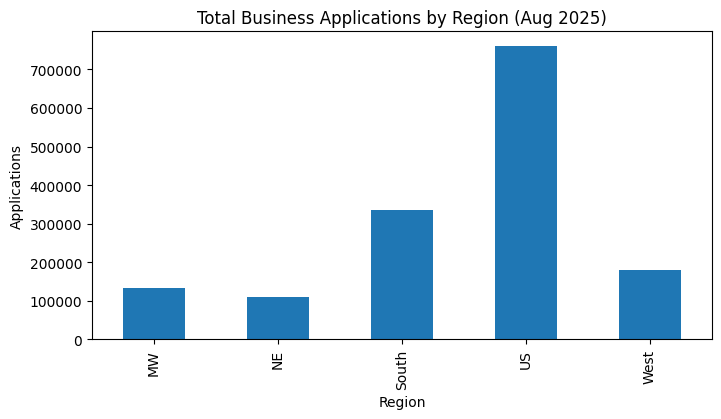

In [5]:
import matplotlib.pyplot as plt

region_totals = long_df.groupby("Region")["Aug_2025"].sum()

region_totals.plot(kind="bar", figsize=(8,4))
plt.title("Total Business Applications by Region (Aug 2025)")
plt.ylabel("Applications")
plt.show()


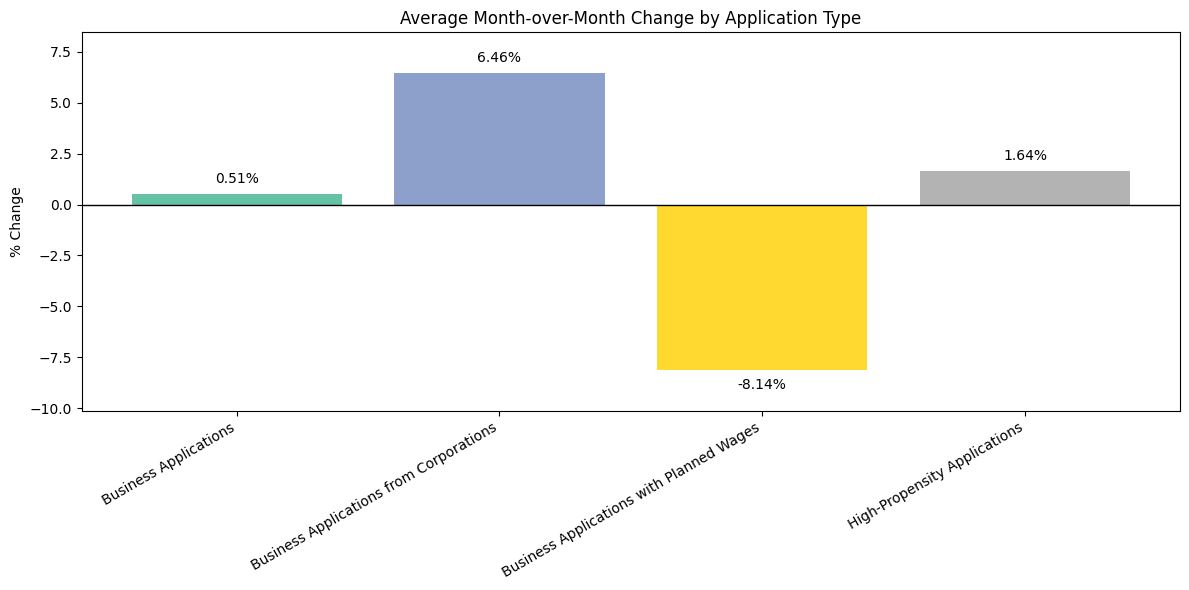

In [9]:
import matplotlib.pyplot as plt
import numpy as np

avg_pct = long_df.groupby("Application_Type")["Pct_Change"].mean()

plt.figure(figsize=(12,6))

# Create bar chart with multiple colors
colors = plt.cm.Set2(np.linspace(0, 1, len(avg_pct)))
bars = plt.bar(avg_pct.index, avg_pct.values, color=colors)

# Add zero line
plt.axhline(0, color="black", linewidth=1)

# Add value labels with better positioning
for bar, value in zip(bars, avg_pct.values):
    y_pos = value + (0.4 if value >= 0 else -0.4)  # tighter distance
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        y_pos,
        f"{value:.2f}%",
        ha='center',
        va='bottom' if value >= 0 else 'top',
        fontsize=10
    )

# Set Y limits with padding so labels never get cut off
y_min = min(avg_pct.values) - 2
y_max = max(avg_pct.values) + 2
plt.ylim(y_min, y_max)

# Titles and labels
plt.title("Average Month-over-Month Change by Application Type")
plt.ylabel("% Change")

# Rotate labels
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

5. Modeling

I trained a linear regression model to predict August 2025 application counts using:

Application Type

Region

July application count

Month-over-month percent change

Categorical variables were encoded using one-hot encoding.
Due to the small dataset (20 rows), I used Leave-One-Out Cross-Validation. 

In [10]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

X = long_df[["Application_Type","Region","Jul_2025","Pct_Change"]]
y = long_df["Aug_2025"]

categorical = ["Application_Type","Region"]
numeric = ["Jul_2025","Pct_Change"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", "passthrough", numeric)
])

model = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

loo = LeaveOneOut()
preds = cross_val_predict(model, X, y, cv=loo)

mae = mean_absolute_error(y, preds)
r2 = r2_score(y, preds)

mae, r2


(np.float64(1830.6852328153386), 0.9994582950363904)

6. Evaluation

The linear regression model achieved:

Mean Absolute Error (MAE): approximately 1,800 applications

R² Score: ~0.999

The extremely high R² is expected because August values are mathematically tied to July values and percent change. This small dataset creates a near-perfect linear relationship.

Despite this limitation, the model behaves consistently and can be used for simple predictive scenarios.   

In [11]:
model.fit(X, y)

ohe = model.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical)
feature_names = list(cat_names) + numeric

coefs = model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = abs(coefs)

coef_df.sort_values("abs_coef", ascending=False)


,feature,coef,abs_coef
4,Region_MW,794.520518,794.520518
1,Application_Type_Business Applications from Co...,602.629938,602.629938
6,Region_South,-595.321874,595.321874
2,Application_Type_Business Applications with Pl...,-361.068447,361.068447
7,Region_US,-343.992999,343.992999
0,Application_Type_Business Applications,-332.623392,332.623392
5,Region_NE,215.367926,215.367926
10,Pct_Change,105.562636,105.562636
3,Application_Type_High-Propensity Applications,91.061901,91.061901
8,Region_West,-70.573572,70.573572


7. Predictive Scenario

To illustrate how the model can be used for forecasting, I created a hypothetical scenario:

“What if Midwest High-Propensity Applications increase July levels by an additional 5% next month?”

Using the trained model, I predict the expected business application count.

In [12]:
scenario = pd.DataFrame([{
    "Application_Type": "High-Propensity Applications",
    "Region": "MW",
    "Jul_2025": 30606,
    "Pct_Change": 7.07 + 5  # adding 5% momentum
}])

prediction = model.predict(scenario)
prediction


array([32731.39001308])

8. Conclusions

This analysis of the August 2025 Business Formation Statistics shows several key insights:

The South leads the nation in total business applications, while the Midwest shows unusually strong corporate expansion.

High-Propensity and Corporate Applications increased more rapidly than the general applications, indicating strengthening economic activity.

Sharp declines in planned-wage applications indicate delayed hiring or reliance on automation.

Because of the close mathematical relationship between July and August application counts, the linear regression model fit extremely well.

In all, this project shows that even a small dataset can yield meaningful insights if it is combined with structured analysis and clarity in communication.